In [1]:
import split
from distance import compute_distance

import time
import pandas as pd
import numpy as np

import matplotlib as plt

import seaborn as sns

import xgboost as xgb

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
splitter = split.Splitter("data",",")
splitter.extract_data("train.csv","key","annee")

Fichiers déjà splitté.


In [3]:
global_train_df = pd.read_csv('data/CURATED/annee/2015.csv', header=0)
global_test_df = pd.read_csv("data/RAW/test.csv", header=0)

In [4]:
train_df = global_train_df.copy()
test_df = global_test_df.copy()

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3856809 entries, 0 to 3856808
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 235.4+ MB


## Nettoyage des données

In [6]:
train_df_clean = train_df[(train_df["fare_amount"] > 0)]
train_df_clean = train_df_clean[(train_df_clean["passenger_count"] > 0)]
train_df_clean = train_df_clean[(train_df_clean["passenger_count"] < 7)]

train_df_clean = train_df_clean[(train_df_clean["pickup_longitude"] != 0)]
train_df_clean = train_df_clean[(train_df_clean["pickup_latitude"] != 0)]
train_df_clean = train_df_clean[(train_df_clean["dropoff_longitude"] != 0)]
train_df_clean = train_df_clean[(train_df_clean["dropoff_latitude"] != 0)]

train_df_clean = train_df_clean[(train_df_clean["pickup_longitude"] <= 180)]
train_df_clean = train_df_clean[(train_df_clean["pickup_latitude"] <= 180)]
train_df_clean = train_df_clean[(train_df_clean["dropoff_longitude"] <= 180)]
train_df_clean = train_df_clean[(train_df_clean["dropoff_latitude"] <= 180)]

train_df_clean = train_df_clean[(train_df_clean["pickup_longitude"] >= -180)]
train_df_clean = train_df_clean[(train_df_clean["pickup_latitude"] >= -180)]
train_df_clean = train_df_clean[(train_df_clean["dropoff_longitude"] >= -180)]
train_df_clean = train_df_clean[(train_df_clean["dropoff_latitude"] >= -180)]

train_df_clean.dropna(inplace=True)
train_df_clean.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-06-21 21:46:34.0000001,22.54,2015-06-21 21:46:34 UTC,-74.010483,40.717667,-73.985771,40.660366,1
1,2015-01-11 03:15:38.0000001,58.00,2015-01-11 03:15:38 UTC,-73.983330,40.738720,-73.933197,40.847225,1
2,2015-03-12 08:08:38.0000001,4.50,2015-03-12 08:08:38 UTC,-73.990173,40.756447,-73.985619,40.762829,1
3,2015-04-12 10:19:05.0000001,11.50,2015-04-12 10:19:05 UTC,-73.979279,40.723438,-74.004608,40.746948,6
4,2015-05-12 23:51:42.0000007,5.00,2015-05-12 23:51:42 UTC,-73.954796,40.779335,-73.944931,40.780087,1


## Calcul de la distance

In [7]:
train_df["distance"] = compute_distance(global_train_df["pickup_latitude"],global_train_df["pickup_longitude"],global_train_df["dropoff_latitude"],global_train_df["dropoff_longitude"])

In [8]:
train_df_clean = train_df[(train_df["distance"] > 0)]
train_df_clean = train_df.drop(columns=['key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_latitude'])

## Forest isolation

In [12]:
model = IsolationForest(n_estimators = 100, max_samples = 'auto', contamination = 'auto', max_features = 1)
model.fit(train_df_clean)
train_df_clean["anomaly"] = model.predict(train_df_clean)
train_df_clean.head(20)

,fare_amount,dropoff_longitude,passenger_count,distance,anomaly
0,22.54,-73.985771,1,7.0,1
1,58.00,-73.933197,1,13.0,-1
2,4.50,-73.985619,1,1.0,1
3,11.50,-74.004608,6,3.0,-1
4,5.00,-73.944931,1,1.0,1
5,5.00,-73.995682,2,1.0,1
6,11.00,-73.959045,2,2.0,1
7,14.00,-74.017464,1,4.0,1
8,16.50,-73.953194,3,6.0,-1
9,9.00,-74.008003,1,3.0,1


In [13]:
anomaly = train_df_clean.loc[train_df_clean['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly)

         fare_amount  dropoff_longitude  passenger_count  distance  anomaly
1              58.00         -73.933197                1      13.0       -1
3              11.50         -74.004608                6       3.0       -1
8              16.50         -73.953194                3       6.0       -1
12             21.50         -73.959435                1       8.0       -1
19             43.50         -74.011345                1      16.0       -1
...              ...                ...              ...       ...      ...
3856778        20.50         -73.932533                1       7.0       -1
3856787        21.50         -74.013878                1       7.0       -1
3856788        22.50         -73.985710                2       9.0       -1
3856803        57.33         -73.980988                1      20.0       -1
3856807        18.00         -74.015221                2       6.0       -1

[638089 rows x 5 columns]


In [14]:
print(len(anomaly))

638089


In [15]:
train_df_clean_final = train_df_clean[train_df_clean["anomaly"]!= -1]

<AxesSubplot:>

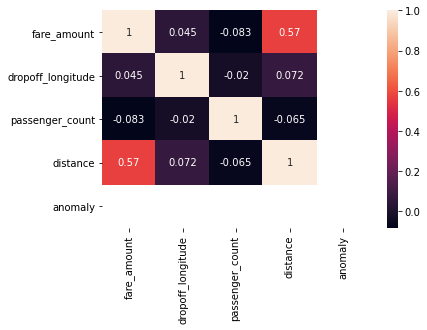

In [19]:
matrice_correlation = train_df_clean_final.corr().round(3)
sns.heatmap(data = matrice_correlation, annot = True)

## Création de modèle

In [20]:
X = pd.DataFrame(train_df_clean_final, columns=['passenger_count','distance'])
y = pd.Series(train_df_clean_final['fare_amount'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)       # Séparation du DF train en train et test

In [22]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

start_time = time.time()
regressor.fit(X_train, y_train)                                     # Entrainement
y_pred_XGB = regressor.predict(X_test)                              # Prediction
end_time = time.time()
print(f"MODEL XGBOOST --- {start_time - end_time} seconds ---")
print(mean_squared_error(y_test, y_pred_XGB))                       # Perte de régression par erreur quadratique moyenne.
print(r2_score(y_test, y_pred_XGB))

MODEL XGBOOST --- -48.66785454750061 seconds ---
7.703272218698742
0.6458076188886807


In [23]:
lmodellineaire = LinearRegression()
start_time = time.time()
lmodellineaire.fit(X_train, y_train)
y_pred_SKL = lmodellineaire.predict(X_test)
end_time = time.time()
print(f"MODEL SKL --- {start_time - end_time} seconds ---")
print(mean_squared_error(y_test, y_pred_SKL))
print(r2_score(y_test, y_pred_SKL))

MODEL SKL --- -0.38519883155822754 seconds ---
12.854267090681578
0.40896759986777864


In [24]:
random_forest = RandomForestRegressor() 
start_time = time.time()
random_forest.fit(X_train, y_train)
y_pred_RF = random_forest.predict(X_test)
end_time = time.time()
print(f"MODEL RF --- {start_time - end_time} seconds ---")
print(mean_squared_error(y_test, y_pred_RF))
print(r2_score(y_test, y_pred_RF))

MODEL RF --- -171.36073756217957 seconds ---
7.7032042704756
0.6458107431120319
